In [89]:
from annoy import AnnoyIndex 
import numpy as np 
import pandas as pd
from sentence_transformers import SentenceTransformer 
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

C:\Users\mats\AppData\Roaming\Python\Python37\site-packages\huggingface_hub\file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [1]:
import sys 
from tqdm import tqdm 
import os 
from random import sample 
from annoy import AnnoyIndex 
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn import metrics 

In [2]:
train_file = './Data/train.csv'
train_enriched_file = './Data/train_enriched.csv'
test_file = './Data/test.csv'
test_enriched = './Data/test_enriched.csv'
embeddings_dim = 384

In [3]:
df = pd.read_csv(train_enriched_file, encoding='utf-8')
df_test = pd.read_csv(test_file,encoding='utf-8')
df_test_enr = pd.read_csv(test_enriched,encoding='utf-8')
df_true = pd.read_csv('./Data/submission.csv', encoding='utf-8')

In [5]:
def encode(text):
    emb = model.encode(text, convert_to_tensor=True).tolist()
    return emb

In [6]:
def label_tweet(testdf,targetdf):
          
    tweets = testdf['emb'].to_list()
    text = testdf['text'].to_list()
    test_ids = testdf['id'].to_list()
    df_pred = pd.DataFrame()
          
    for tweet,tx,t_id in zip(tweets,text,test_ids):
              
        df_temp = pd.DataFrame()
        search_res = annoy_index.get_nns_by_vector(tweet,n=1,search_k=-1,include_distances=False)
        d = {t_id: [t_id, tx, search_res[0]]}
        df_temp = pd.DataFrame.from_dict(d, orient = 'index', columns=['test_id','text', 'target_id'])
        df_pred = pd.concat([df_pred,df_temp])
          
          
    df_pred = df_pred.merge(targetdf[['id','target']], right_on='id', left_on='target_id', how='left')
                                  
    #mergedf = targetdf[['id','target']]
          
    return df_pred

In [7]:
df['tx_key'] = df['text'] + ' ' + df['keyword'].apply(lambda x: x if x != 'no_keyword' else '')
df.head(2)

,id,keyword,text,target,word_count,unique_words_count,Tweet_len,special_chars_count,hash_count,@_count,URL_count,sentiment,subjectivity,dis%,text_clean,keyword_clean,newtext,tx_key
0,1,no_keyword,Our Deeds are the Reason of this #earthquake M...,1,13,13,69,1,1,0,0,0.0,0.0,no_keyword,deed reason #earthquak may allah forgiv,nokeyword,deed reason #earthquak may allah forgiv,Our Deeds are the Reason of this #earthquake M...
1,4,no_keyword,Forest fire near La Ronge Sask. Canada,1,7,7,38,1,0,0,0,0.1,0.4,no_keyword,forest fire near la rong sask. canada,nokeyword,forest fire near la rong sask. canada,Forest fire near La Ronge Sask. Canada


In [8]:
df['emb'] = df['text'].apply(lambda t: encode(t))

In [10]:
df_test_enr['tx_key'] = df_test_enr['text'] + ' ' + df_test_enr['keyword'].apply(lambda x: x if x != 'no_keyword' else '')
df_test_enr.head(2)

,id,keyword,text,text_clean,keyword_clean,newtext,tx_key
0,0,no_keyword,Just happened a terrible car crash,happen terribl car crash,nokeyword,happen terribl car crash,Just happened a terrible car crash
1,2,no_keyword,"Heard about #earthquake is different cities, s...","heard #earthquak differ cities, stay safe ever...",nokeyword,"heard #earthquak differ cities, stay safe ever...","Heard about #earthquake is different cities, s..."


In [11]:
df_test_enr['emb'] = df_test_enr['text'].apply(lambda t: encode(t))

In [48]:
df.to_csv('./Data/train_emb.csv', encoding='utf-8', index=False)
df_test_enr.to_csv('./Data/test_emb.csv', encoding='utf-8', index=False)

## build annoy

In [12]:
embeddings = df['emb'].to_list()
tweets_ids = df['id'].to_list()

In [37]:
annoy_index = AnnoyIndex(embeddings_dim, 'angular')

In [38]:
for tweet_id, embedding in zip(tweets_ids,embeddings):
    if len(embedding) != embeddings_dim:
        print('wrong dim lenght')
        continue 
    annoy_index.add_item(tweet_id,embedding)

In [39]:
annoy_index.build(150) #,n_jobs=-1)
annoy_index.save('./Data/annoy_index.ann')

True

## load built annoy

In [31]:
# annoy_index = AnnoyIndex(embeddings_dim, 'angular')
# annoy_index.load('./Data/annoy_index.ann')

In [36]:
#annoy_index.unload()

True

## search for similarities

In [40]:
df_pred = label_tweet(df_test_enr,df)

In [41]:
df_pred.head()

,test_id,text,target_id,id,target
0,0,Just happened a terrible car crash,2645,2645,0
1,2,"Heard about #earthquake is different cities, s...",4397,4397,1
2,3,"there is a forest fire at spot pond, geese are...",10481,10481,1
3,9,Apocalypse lighting. #Spokane #wildfires,10519,10519,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,2991,2991,1


## label single tweet

In [52]:
# from sentence_transformers import SentenceTransformer 
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
annoy_index = AnnoyIndex(embeddings_dim, 'angular')
annoy_index.load('./Data/annoy_index.ann')

In [84]:
def label_tweets(tweet, annoy):
    
    target = pd.read_csv('./Data/train.csv', encoding='utf-8', usecols = ['id', 'target'])
    emb_tweet = model.encode(tweet, convert_to_tensor=True).tolist()
    label_id = annoy.get_nns_by_vector(emb_tweet,n=1,search_k=-1,include_distances=False)
    
    label = target.loc[target['id']==label_id[0], ['target']].values[0][0]
    
    return label

In [88]:
while True:
    i = input("Enter a tweet text: ")

    if i == "quit":
        break
    else:
          print(label_tweets(i, annoy_index))  
            
# 0 not a disaster
# 1     a disaster

Enter a tweet text: Yasir Al Shahrani's game by numbers vs. Argentina:  ◉ Most clearances (6) ◉ Most interceptions (6) ◉ Most offside traps (4) ◎ 5 x possession won ◎ 3 tackles made ◎ 3 duels won ◎ 0 x dribbled past  He put his body on the line for his country.  #FIFAWorldCup
0
Enter a tweet text: ⛔A terrible earthquake in Indonesia killed 162 people. ⛔Today, earthquakes with a magnitude of 5.6 destroyed about 2,000 homes, more than 700 people were injured, and evacuations continue. #Earthquake #Destroyed
1
Enter a tweet text: earthquake
1
Enter a tweet text: evacuations
1
Enter a tweet text: thunderstorm
0
Enter a tweet text: tornado
1
Enter a tweet text: magnitude
0
Enter a tweet text: destroyed
0
Enter a tweet text: car crash
1
Enter a tweet text: fire alarm
1
Enter a tweet text: 700 people were sick
1
Enter a tweet text: quit


## <font color = 'dark green'> metrics 

In [42]:
y_pred = df_pred['target']
y = df_true['target']

In [43]:
accuracy = accuracy_score(y,y_pred)
f1 = f1_score(y,y_pred,average='macro')
precision = precision_score(y,y_pred,average='macro')
recall = recall_score(y,y_pred,average='macro')

print(f'Accuracy  {accuracy}')
print(f'F1        {f1}')
print(f'Precision {precision}')
print(f'Recall    {recall}')

Accuracy  0.7707631014403923
F1        0.7676616176616177
Precision 0.7665832965914101
Recall    0.7697418901837476


In [44]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1861
           1       0.72      0.76      0.74      1402

    accuracy                           0.77      3263
   macro avg       0.77      0.77      0.77      3263
weighted avg       0.77      0.77      0.77      3263



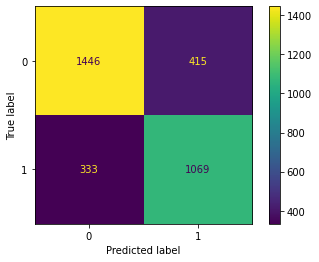

In [45]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

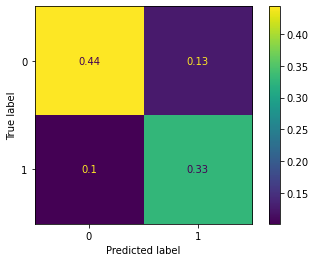

In [46]:
cm = confusion_matrix(y, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()